In [1]:
# %% [markdown]
# # Fine-tuning modelu tłumaczenia PL→EN z wykorzystaniem LoRA
#
# W tym notebooku:
# 1. Instalujemy potrzebne paczki
# 2. Ładujemy dane (WMT16 PL–EN)
# 3. Tworzymy tokenizer i model
# 4. Konfigurujemy LoRA (PEFT)
# 5. Przygotowujemy dane (tokenizacja)
# 6. Definiujemy Trainer i trenujemy
# 7. Zapisujemy model i testujemy inferencję

# %%
# ### 1. Instalacja pakietów
!pip install transformers datasets accelerate peft sacrebleu sentencepiece

In [2]:
# %% [markdown]
# ### 2. Importy i ustawienia globalne

# %%
import os
import time
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments, Seq2SeqTrainer,
    DataCollatorForSeq2Seq, pipeline
)
from peft import LoraConfig, get_peft_model
import sacrebleu

# Ustaw ścieżkę do zapisu
OUTPUT_DIR = "mt-pl-en-lora"

/Users/amika/python-global/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import get_dataset_config_names

print(get_dataset_config_names("opus100"))
# Powinieneś zobaczyć listę języków, w tym "pl-en"


['af-en', 'am-en', 'an-en', 'ar-de', 'ar-en', 'ar-fr', 'ar-nl', 'ar-ru', 'ar-zh', 'as-en', 'az-en', 'be-en', 'bg-en', 'bn-en', 'br-en', 'bs-en', 'ca-en', 'cs-en', 'cy-en', 'da-en', 'de-en', 'de-fr', 'de-nl', 'de-ru', 'de-zh', 'dz-en', 'el-en', 'en-eo', 'en-es', 'en-et', 'en-eu', 'en-fa', 'en-fi', 'en-fr', 'en-fy', 'en-ga', 'en-gd', 'en-gl', 'en-gu', 'en-ha', 'en-he', 'en-hi', 'en-hr', 'en-hu', 'en-hy', 'en-id', 'en-ig', 'en-is', 'en-it', 'en-ja', 'en-ka', 'en-kk', 'en-km', 'en-kn', 'en-ko', 'en-ku', 'en-ky', 'en-li', 'en-lt', 'en-lv', 'en-mg', 'en-mk', 'en-ml', 'en-mn', 'en-mr', 'en-ms', 'en-mt', 'en-my', 'en-nb', 'en-ne', 'en-nl', 'en-nn', 'en-no', 'en-oc', 'en-or', 'en-pa', 'en-pl', 'en-ps', 'en-pt', 'en-ro', 'en-ru', 'en-rw', 'en-se', 'en-sh', 'en-si', 'en-sk', 'en-sl', 'en-sq', 'en-sr', 'en-sv', 'en-ta', 'en-te', 'en-tg', 'en-th', 'en-tk', 'en-tr', 'en-tt', 'en-ug', 'en-uk', 'en-ur', 'en-uz', 'en-vi', 'en-wa', 'en-xh', 'en-yi', 'en-yo', 'en-zh', 'en-zu', 'fr-nl', 'fr-ru', 'fr-zh', 

In [4]:
# %% [markdown]
# ### 3. Ładowanie danych (subset OPUS100 en-pl)

# %%
from datasets import load_dataset

# 1) Pobieramy OPUS100 en-pl:
raw = load_dataset("opus100", "en-pl")

# 2) Wybieramy małe subsety na początek:
train_raw = raw["train"].shuffle(seed=42).select(range(20000))
val_raw = raw["validation"].shuffle(seed=42).select(range(2000))

print(f"Train samples: {len(train_raw)}, Validation samples: {len(val_raw)}")
print(train_raw[0]["translation"])
# → powinno wyświetlić coś w stylu {'en': 'This is a sentence.', 'pl': 'To jest zdanie.'}


Train samples: 20000, Validation samples: 2000
{'en': "I'm sure you do.", 'pl': 'Zapewne tak.'}


In [5]:
# %% [markdown]
# ### 4. Tokenizer i bazowy model

# %%
MODEL_ID = "Helsinki-NLP/opus-mt-pl-en"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

# szybki test pipeline-u
translator = pipeline("translation", model=base_model, tokenizer=tokenizer)
print("Przykład:", translator("To jest test zdania."))



Device set to use mps:0


Przykład: [{'translation_text': 'This is a sentence test.'}]


In [7]:

# 5. Konfiguracja LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(base_model, lora_config)

# 5.1 Sprawdzenie konfiguracji
adapter = model.active_adapter  # zazwyczaj "default"
conf = model.peft_config[adapter]
print("Aktywny adapter:", adapter)
print("Target modules:", conf.target_modules)


Aktywny adapter: default
Target modules: {'q_proj', 'v_proj'}


/Users/amika/python-global/lib/python3.12/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/Users/amika/python-global/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [9]:
# %% [markdown]
# ### 6. Funkcja preprocessująca i tokenizacja (poprawiona)

# %%
max_len = 128


def preprocess(batch):
    # batch["translation"] to lista dictów {'en': ..., 'pl': ...}
    src_texts = [t["pl"] for t in batch["translation"]]
    tgt_texts = [t["en"] for t in batch["translation"]]

    # tokenizacja wejścia
    model_inputs = tokenizer(
        src_texts,
        truncation=True,
        padding="max_length",
        max_length=max_len
    )
    # tokenizacja etykiet
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            tgt_texts,
            truncation=True,
            padding="max_length",
            max_length=max_len
        ).input_ids

    model_inputs["labels"] = labels
    return model_inputs


# zastosowanie map na danych
train_ds = train_raw.map(
    preprocess,
    batched=True,
    remove_columns=train_raw.column_names
)
val_ds = val_raw.map(
    preprocess,
    batched=True,
    remove_columns=val_raw.column_names
)

print(train_ds)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]/Users/amika/python-global/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 2000/2000 [00:00<00:00, 9983.53 examples/s] 

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 20000
})


In [10]:
# %% [markdown]
# ### 7. DataCollator i metryki (BLEU)

# %%
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


def compute_metrics(eval_pred):
    preds, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score}



In [16]:
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    predict_with_generate=True,

    # strategia ewaluacji
    eval_strategy="steps",
    eval_steps=500,

    # strategia zapisu
    save_strategy="steps",
    save_steps=500,

    logging_steps=100,
    num_train_epochs=3,
    fp16=False,  # lub True, jeśli masz GPU z FP16

    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)


In [17]:
# %% [markdown]
# ### 9. Inicjalizacja i uruchomienie Trainer

# %%
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()



/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_21716/74575465.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Bleu
500,0.160400,0.196286,8.534518
1000,0.157200,0.194469,10.207711
1500,0.163000,0.193122,12.053509
2000,0.159600,0.192120,11.912978
2500,0.151100,0.191361,13.503544
3000,0.160900,0.190978,14.262612
3500,0.158000,0.190830,14.289325


/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a692e804-

TrainOutput(global_step=3750, training_loss=0.2754562779744466, metrics={'train_runtime': 24722.0576, 'train_samples_per_second': 2.427, 'train_steps_per_second': 0.152, 'total_flos': 2047491440640000.0, 'train_loss': 0.2754562779744466, 'epoch': 3.0})

In [18]:
# %% [markdown]
# ### 10. Zapis finalnego modelu

# %%
model.save_pretrained(os.path.join(OUTPUT_DIR, "lora"))
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "lora"))



('mt-pl-en-lora/lora/tokenizer_config.json',
 'mt-pl-en-lora/lora/special_tokens_map.json',
 'mt-pl-en-lora/lora/vocab.json',
 'mt-pl-en-lora/lora/source.spm',
 'mt-pl-en-lora/lora/target.spm',
 'mt-pl-en-lora/lora/added_tokens.json')

In [19]:
# %% [markdown]
# ### 11. Test inferencji na zapisanym modelu

# %%
from transformers import pipeline as _pipe

pipe = _pipe("translation", model=os.path.join(OUTPUT_DIR, "lora"), tokenizer=tokenizer)
print(pipe("Dzień dobry, to jest przykład testowy."))

Device set to use mps:0


[{'translation_text': 'Good morning, this is a test example.'}]


In [20]:
test_sentences = [
    "To jest test.",
    "Lubię jabłka.",
    "On poszedł do sklepu, ale zapomniał portfela.",
    "Jeżeli pada deszcz, weź parasol.",
    "Warszawa jest stolicą Polski i największym miastem kraju.",
    "Pomimo że spóźniliśmy się na pociąg, udało nam się złapać następny.",
    "Chociaż programista był zmęczony, kontynuował pracę nad projektem, aby dotrzymać terminu.",
    "Przyczyną awarii systemu była niezgodność wersji oprogramowania oraz niewłaściwe ustawienie parametrów.",
    "W obliczu nieuchronnej katastrofy, ludzie musieli szybko podjąć decyzję o ewakuacji.",
    "Ten złożony algorytm optymalizacyjny wykorzystuje gradienty skokowe i heurystyki, aby znaleźć globalne minimum funkcji w przestrzeni wielowymiarowej.",
    "Chcę napisać esej porównujący filozofię Platona z dialektyką Hegla i ich wpływ na współczesne myślenie polityczne.",
    "Mimo że życie potrafi być nieprzewidywalne, ważne jest, aby zachować spokój i elastyczność w podejmowaniu codziennych decyzji."
]

for sent in test_sentences:
    output = pipe(sent)[0]['translation_text']
    print(f"🔹 Źródło: {sent}")
    print(f"   Tłumaczenie: {output}\n")

🔹 Źródło: To jest test.
   Tłumaczenie: This is a test.

🔹 Źródło: Lubię jabłka.
   Tłumaczenie: I like apples.

🔹 Źródło: On poszedł do sklepu, ale zapomniał portfela.
   Tłumaczenie: He went to the store, but he forgot his wallet.

🔹 Źródło: Jeżeli pada deszcz, weź parasol.
   Tłumaczenie: If it rains, take an umbrella.

🔹 Źródło: Warszawa jest stolicą Polski i największym miastem kraju.
   Tłumaczenie: Warsaw is the capital of Poland and the largest city of the country.

🔹 Źródło: Pomimo że spóźniliśmy się na pociąg, udało nam się złapać następny.
   Tłumaczenie: Even though we missed the train, we managed to catch the next one.

🔹 Źródło: Chociaż programista był zmęczony, kontynuował pracę nad projektem, aby dotrzymać terminu.
   Tłumaczenie: Although the programmer was tired, he continued to work on the project to meet the deadline.

🔹 Źródło: Przyczyną awarii systemu była niezgodność wersji oprogramowania oraz niewłaściwe ustawienie parametrów.
   Tłumaczenie: The cause of the sy

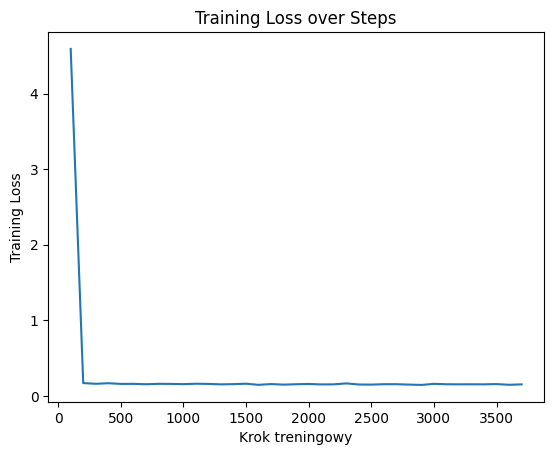

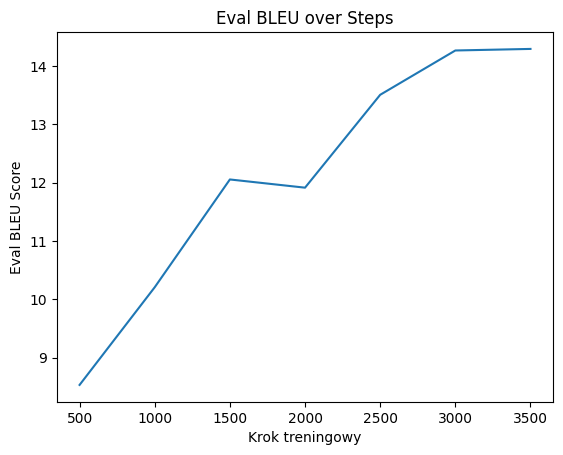

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Sprawdzamy, czy obiekt 'trainer' jest zdefiniowany
if 'trainer' not in globals():
    print("Proszę uruchomić wcześniej komórkę z definiowaniem i treningiem obiektu `trainer`, aby wygenerować wykresy.")
else:
    # Wczytujemy historię logów z treningu
    history = trainer.state.log_history
    df = pd.DataFrame(history)

    # Filtrujemy loss i BLEU
    loss_df = df[['step', 'loss']].dropna()
    bleu_df = df[['step', 'eval_bleu']].dropna()

    # Wykres 1: Loss w trakcie treningu
    plt.figure()
    plt.plot(loss_df['step'], loss_df['loss'])
    plt.xlabel('Krok treningowy')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Steps')
    plt.show()

    # Wykres 2: BLEU Score w trakcie ewaluacji
    plt.figure()
    plt.plot(bleu_df['step'], bleu_df['eval_bleu'])
    plt.xlabel('Krok treningowy')
    plt.ylabel('Eval BLEU Score')
    plt.title('Eval BLEU over Steps')
    plt.show()
